<a id='top'></a><a name='top'></a>
# Chapter 4: Word and Sentence Embeddings

## 4.1 Word Embeddings

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/gbih/nlp/blob/main/ja_nlp_book/chp04_4_1_word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

* [Setup](#setup)
* [4.1 Word Embeddings](#4.1)
    - [4.1.1 What are Word Embeddings?](#4.1.1)
    - [4.1.2 Interacting with Japanese Word Embeddings](#4.1.2)
    - [4.1.3 Training Japanese Word Embeddings with Gensim](#4.1.3)

---
<a name='setup'></a><a id='setup'></a>
# Setup
<a href="#top">[back to top]</a>

In [ ]:
import pathlib
from pathlib import Path

data_root = Path("chp04_01")
req_file = data_root / "requirements_4_4_1.txt"

if not data_root.is_dir():
    data_root.mkdir()
else:
    print(f"{data_root} exists.")

In [ ]:
%%writefile {req_file}
fugashi[unidic]==1.2.1
gensim==4.2.0
japanize_matplotlib==1.1.3
unidic_lite==1.0.8
watermark==2.3.1

Writing chp04_01/requirements_4_4_1.txt


In [ ]:
import sys
import os
check1 = ('google.colab' in sys.modules)
check2 = (os.environ.get('CLOUDSDK_CONFIG')=='/content/.config')
IS_COLAB = True if (check1 or check2) else False

if IS_COLAB:
    print("Installing packages")
    !pip install --quiet -r {req_file}
    !python -m unidic download
    print("Packages installed.")
else:
    print("Running locally.")

Installing packages
     |████████████████████████████████| 615 kB 26.3 MB/s 
     |████████████████████████████████| 24.1 MB 93.1 MB/s 
     |████████████████████████████████| 4.1 MB 55.6 MB/s 
     |████████████████████████████████| 47.4 MB 85 kB/s 
     |████████████████████████████████| 1.6 MB 31.1 MB/s 
download url: https://cotonoha-dic.s3-ap-northeast-1.amazonaws.com/unidic-3.1.0.zip
Dictionary version: 3.1.0+2021-08-31
unidic-3.1.0.zip: 100% 526M/526M [00:13<00:00, 39.1MB/s]
Finished download.
Downloaded UniDic v3.1.0+2021-08-31 to /usr/local/lib/python3.8/dist-packages/unidic/dicdir
Packages installed.


In [ ]:
# Standard Library imports
from importlib.metadata import version
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppress TensorFlog log messages
import pathlib
from pathlib import Path
import shlex
import shutil
import subprocess
import sys

# Third-party imports
import fugashi
from fugashi import Tagger
import gensim
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import sample
import sklearn
from sklearn.manifold import TSNE
import seaborn as sns
sns.set(font="IPAexGothic")
import tensorflow as tf
import tensorflow_datasets as tfds
from watermark import watermark

def HR():
    print("-"*50)

# Examine all imported packages
print(watermark(iversions=True, globals_=globals(),python=True, machine=False))

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 7.9.0

sys                : 3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]
tensorflow         : 2.9.2
pathlib            : 1.0.1
numpy              : 1.21.6
gensim             : 4.2.0
matplotlib         : 3.2.2
pandas             : 1.3.5
sklearn            : 1.0.2
fugashi            : 1.2.1
japanize_matplotlib: 1.1.3
tensorflow_datasets: 4.6.0
seaborn            : 0.11.2



In [ ]:
assert version('fugashi') == '1.2.1'
assert version('gensim') == '4.2.0'
assert version('japanize_matplotlib') == '1.1.3'
assert version('unidic_lite') == '1.0.8'

print("Successfully imported specified packages.")

Successfully imported specified packages.


---
<a name='4.1'></a><a id='4.1'></a>
# 4.1 Word Embeddings
<a href="#top">[back to top]</a>

<a name='4.1.1'></a><a id='4.1.1'></a>
## 4.1 What are Word Embeddings?
<a href="#top">[back to top]</a>

**Concept**

Embeddings are continuous vector representations of something that is usually discrete. Since they are continuous, they can be transitioned in a smooth way.

Word embeddings are continuous, real-valued vector representation of natural language words. They are the building blocks for modern deep learning methods that bridge between discrete symbols and meaning. 

These vectors are designed so that conceptually and linguistically similar words have similar values. 

Word embeddings are important because they provide numbers corresponding to some linguistic and/or semantic properties of words. If you change the value of thoese vectors a little, you should still have similar meanings.

**Mechanism**

Commonly used algorithms for word embedding are SkipGram and CBOW.

SkipGram trains embeddings so these vectors can predict the vectors of other words that fall within their contect.  SkipGram and CBOW (a SkipGram variant) are collectively called Word2Vec.

**Implementation**

Word embeddings can be trained from readily available large collections of plain text documents, without human annotation, via "self-supervision".

 Work embeddings trained from large corpora are useful themselves, although they are usually used in conjunction with other machine learning models for solving downstream tasks. This technique of training a model or set of embeddings for one task (pretraining) and applying it to another (fine-tuning) is called transfer-learning.

**Reference**

* http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
* https://neptune.ai/blog/word-embeddings-guide



<a name='4.1.2'></a><a id='4.1.2'></a>
## 4.1.2 Interacting with Japanese Word Embeddings
<a href="#top">[back to top]</a>

**Introduction**

There are many publicly available Japanese word embeddings:

* NWJC2vec
* hottoSNS-w2v
* fastText
* chiVe
* Wikipedia2Vec

Most of these use SkipGram/CBOW to train word embeddings, although differ in their choice of corpora for pretraining. 

chiVe uses NWCJ as the pretraining corpus and Sudachi for word segmentation and normalizating. It is one of the largest Japanese embeddings datasets available today, without over 3 million vocabulary items. 

**Workflow**

* 4.1.2 Interacting with chiVe Japanese Word Embedding
    - Download, load and visualize chiVe word embeddings
* 4.1.3 Training Japanese Word Embeddings with Gensim
    - Train our own embedddings by downloading Wikipedia text with Gensim.


### Loading chiVe

chiVe: Japanese Word Embedding with Sudachi & NWJC


| Version   | Normalized | Min Count | Vocab     | Sudachi | SudachiDict           | Text                                                                                          | gensim| Magnitude                                              |
| --------- | ---------- | --------- | --------- | ------- | --------------------- | --------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------- |
| v1.2 mc30 | o      | 30       | 912,550   | v0.4.3 | 20200722-core         | 3.1GB ([tar.gz](https://sudachi.s3-ap-northeast-1.amazonaws.com/chive/chive-1.2-mc30.tar.gz)) | 1.1GB ([tar.gz](https://sudachi.s3-ap-northeast-1.amazonaws.com/chive/chive-1.2-mc30_gensim.tar.gz)) | 1.5GB ([.magnitude](https://sudachi.s3-ap-northeast-1.amazonaws.com/chive/chive-1.2-mc30.magnitude)) |



In [ ]:
data_file = "chive-1.2-mc30.tar.gz"
data_url = f"https://sudachi.s3-ap-northeast-1.amazonaws.com/chive/{data_file}"
data_dir = Path("chp04_01")
data_src = data_dir / data_file
data_ver = data_dir / "word_embeddings" / "v1.2"
data_path = data_ver / "chive-1.2-mc30/chive-1.2-mc30.txt"

print(f"""
data_file:\t{data_file}
data_url:\t{data_url}
data_dir:\t{data_dir}
data_src:\t{data_src}
data_ver:\t{data_ver}
data_path:\t{data_path}
""")


data_file:	chive-1.2-mc30.tar.gz
data_url:	https://sudachi.s3-ap-northeast-1.amazonaws.com/chive/chive-1.2-mc30.tar.gz
data_dir:	chp04_01
data_src:	chp04_01/chive-1.2-mc30.tar.gz
data_ver:	chp04_01/word_embeddings/v1.2
data_path:	chp04_01/word_embeddings/v1.2/chive-1.2-mc30/chive-1.2-mc30.txt



In [ ]:
if not data_src.is_file():
    print(f"Downloading {data_url}")
    subprocess.run(shlex.split(f"wget -q -O {data_src} {data_url}"))
    print("Done.")
else:
    print(f"{data_src} exists.")

Done.


In [ ]:
if not data_path.is_file():
    os.makedirs(data_path)
    print("Extracting file")
    subprocess.run(shlex.split(f"tar -xvf {data_src} -C {data_ver}"))
    print("Done.")
else:
    print(f"{data_path} exists")

Extracting file
Done.


### Using chiVe with Gensim

In [ ]:
model_pretrained_dir = data_dir / "models_pretrained"
model_pretrained_path = model_pretrained_dir / "chiVe_word2vec_model"
print(model_pretrained_dir)
print(model_pretrained_path)

if not Path(model_pretrained_dir).is_dir():
    model_pretrained_dir.mkdir(parents=True, exist_ok=False)

chp04_01/models_pretrained
chp04_01/models_pretrained/chiVe_word2vec_model


In [ ]:
if not model_pretrained_path.is_file():
    print("Creating model based on pretrained Japanese word embeddings.")
    print("This may take awhile.")
    vectors = gensim.models.KeyedVectors.load_word2vec_format(
        data_path,
        binary=False
    )
    print("Done training.")
    vectors.save(str(model_pretrained_path))
    print("Model saved as {model_pretrained_path}.")
else:
    print(f"{model_pretrained_path} exists.")

Creating model based on pretrained Japanese word embeddings.
This may take awhile.
Done training.
Model saved as {model_pretrained_path}.


In [ ]:
# Make sure we can load the model
vectors = gensim.models.KeyedVectors.load(str(model_pretrained_path))
print(type(vectors))
print(f"{len(vectors):,}")

<class 'gensim.models.keyedvectors.KeyedVectors'>
912,550


Note that ネコ is not in the embeddings since ChiVe normalizes words.

In [ ]:
print('猫' in vectors)
print('ネコ' in vectors)
print('ねこ' in vectors)

True
False
False


In [ ]:
try:
    vectors.most_similar("ネコ", topn=10)
except KeyError as e:
    print(f"Error as {e}")

Error as "Key 'ネコ' not present in vocabulary"


In [ ]:
vectors.most_similar("猫", topn=10)

[('にゃんこ', 0.8185642957687378),
 ('子猫', 0.7982743382453918),
 ('飼い猫', 0.7705047726631165),
 ('野良猫', 0.7286666631698608),
 ('犬', 0.7257893085479736),
 ('三毛', 0.7169792056083679),
 ('家猫', 0.7151225209236145),
 ('愛猫', 0.7149956822395325),
 ('にゃん', 0.7095625400543213),
 ('ニャン', 0.7001851797103882)]

In [ ]:
vectors.most_similar(positive=['沖縄', '札幌'], negative=['那覇'])

[('北海道', 0.7786420583724976),
 ('北海道内', 0.5606185793876648),
 ('北海道札幌市', 0.5590070486068726),
 ('旭川', 0.5544772744178772),
 ('函館', 0.5488263368606567),
 ('道内', 0.5478829145431519),
 ('札幌市', 0.546139657497406),
 ('道産子', 0.5395426154136658),
 ('道南', 0.528639018535614),
 ('新潟', 0.5133264660835266)]

In [ ]:
vectors.most_similar(positive=['見る','聞こえる'], negative=['見える'])

[('聞く', 0.6801009774208069),
 ('聞き直す', 0.5750247836112976),
 ('大音量', 0.5382360219955444),
 ('音', 0.5228562951087952),
 ('聞き覚え', 0.5185920596122742),
 ('声', 0.5179462432861328),
 ('聞き取る', 0.5163859128952026),
 ('聞き比べる', 0.5059888362884521),
 ('遣る', 0.49012014269828796),
 ('耳障り', 0.4877479076385498)]

In [ ]:
vectors.most_similar(positive=['ドッグ', '猫'], negative=['犬'])

[('キャット', 0.6017878651618958),
 ('にゃんこ', 0.580923318862915),
 ('子猫', 0.5144534111022949),
 ('にゃん', 0.4969930350780487),
 ('ドック', 0.491255521774292),
 ('虎猫', 0.47515347599983215),
 ('白猫', 0.47507280111312866),
 ('野良猫', 0.4739617109298706),
 ('にゃあ', 0.4642661511898041),
 ('猫好き', 0.45992711186408997)]

In [ ]:
# Which one of these five is out of place?
# Four stations are on the Yamanote-line.
vectors.doesnt_match(['新宿', '渋谷', '品川', '池袋', '大手町'])

'大手町'

In [ ]:
print(vectors.doesnt_match("新宿 渋谷 品川 池袋 大手町".split()))

大手町


### Visualize chiVe word embeddings

Plot word embeddings on a 2D plane with t‐SNE, an algorithm that maps high‐dimensional vectors onto a low‐dimensional space.

**Reference**

[sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

This is a popular non-linear dimensionality technique.

t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data

The main purpose of t-SNE is visualization of high-dimensional data. Hence, it works best when the data will be embedded on two or three dimensions.

It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high.

In [ ]:
FIG_SIZE = (10, 8)
FONT_SIZE = 12
ALPHA = 0.75
SCATTER_SIZE = 10

In [ ]:
words_n = 500
print(f"Original length: {len(vectors.index_to_key):,}")
print(f"Subset length: {words_n}")

# In order to be able to use learning_rate='auto' in TSNE constructor, 
# vectors_subset needs to have a shape, hence we convert this list to a Numpy array.
vectors_subset = np.array([vectors[w] for w in vectors.index_to_key[:words_n]])

print(f"Dataset shape: {vectors_subset.shape}") 

Original length: 912,550
Subset length: 500
Dataset shape: (500, 300)


In [ ]:
type(vectors_subset)

numpy.ndarray

In [ ]:
# Quick check of the data
df = pd.DataFrame(vectors_subset)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-0.046912,0.084880,0.046354,0.060074,-0.010447,0.066487,0.032758,-0.098352,-0.038612,-0.115540,...,-0.202620,-0.019110,-0.097014,0.004956,-0.014775,0.029389,-0.025768,0.205889,0.124697,-0.030300
std,0.168029,0.124094,0.134283,0.134201,0.135724,0.141035,0.140315,0.126701,0.128525,0.136155,...,0.145912,0.139819,0.140244,0.135615,0.141364,0.126798,0.166841,0.136556,0.136686,0.152925
min,-0.695569,-0.277611,-0.336241,-0.437518,-0.437396,-0.515730,-0.429594,-0.531148,-0.446759,-0.609678,...,-0.609951,-0.516045,-0.568548,-0.455846,-0.529649,-0.347447,-0.542999,-0.250213,-0.270484,-0.578979
25%,-0.140938,0.010805,-0.030068,-0.025669,-0.094798,-0.027888,-0.048756,-0.178116,-0.124451,-0.194373,...,-0.298273,-0.101844,-0.200059,-0.086647,-0.100759,-0.049477,-0.139802,0.120107,0.034642,-0.126089
50%,-0.031305,0.085492,0.051753,0.055766,-0.007104,0.060282,0.045218,-0.094418,-0.048225,-0.115312,...,-0.214997,-0.033701,-0.099158,-0.001542,-0.013498,0.024849,-0.007908,0.218603,0.122917,-0.029878
75%,0.069630,0.162748,0.127242,0.145895,0.077526,0.153632,0.124309,-0.017379,0.039216,-0.030418,...,-0.108077,0.065337,-0.007973,0.088331,0.085196,0.103068,0.096206,0.306262,0.208820,0.065301
max,0.357235,0.468239,0.524352,0.510831,0.418362,0.718967,0.462566,0.293554,0.428846,0.345752,...,0.269447,0.470008,0.357554,0.500136,0.509711,0.590463,0.428312,0.590523,0.541322,0.500087


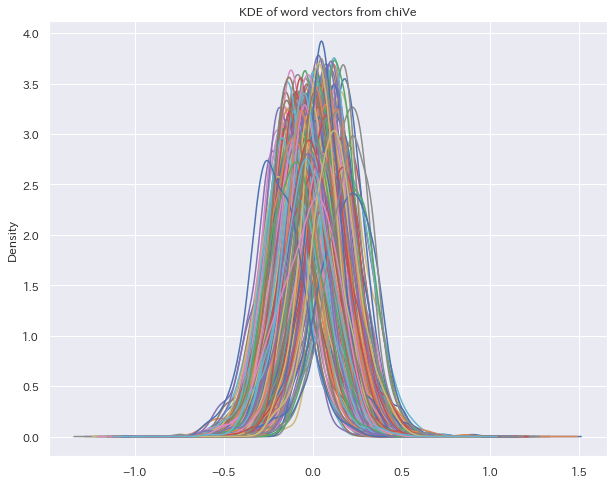

In [ ]:
# The data already looks to be normalized.
df.plot.kde(legend=False, figsize=FIG_SIZE)
plt.title("KDE of word vectors from chiVe")

plt.show()

In [ ]:
# Map word embeddings to two-dimensional vectors.
# This is an embedding of the training data in low-dimensional space.

# First, convert affinities of data points to probabilities.
x_embedded_prob = TSNE(
    n_components=2, # Use for a 2D graph
    random_state=42,
    learning_rate='auto',
    init='pca',
    verbose=1
)

x_embedded_prob

TSNE(init='pca', learning_rate='auto', random_state=42, verbose=1)

In [ ]:
# Check other parameter defaults
x_embedded_prob.get_params()

{'angle': 0.5,
 'early_exaggeration': 12.0,
 'init': 'pca',
 'learning_rate': 'auto',
 'method': 'barnes_hut',
 'metric': 'euclidean',
 'min_grad_norm': 1e-07,
 'n_components': 2,
 'n_iter': 1000,
 'n_iter_without_progress': 300,
 'n_jobs': None,
 'perplexity': 30.0,
 'random_state': 42,
 'square_distances': 'legacy',
 'verbose': 1}

In [ ]:
# Return ndarray of shape (n_samples, n_components)
x_embedded = x_embedded_prob.fit_transform(vectors_subset)
print("Done")
print(x_embedded.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.746049


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.368637
[t-SNE] KL divergence after 1000 iterations: 1.295889
Done
(500, 2)


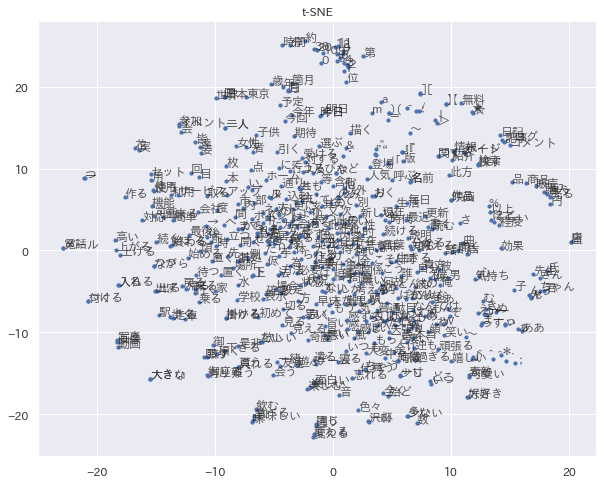

In [ ]:
plt.figure(figsize=FIG_SIZE)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], s=SCATTER_SIZE)
plt.title("t-SNE")

for label, x, y in zip(
    vectors.index_to_key[:words_n],
    x_embedded[:, 0],
    x_embedded[:, 1]):
    plt.annotate(label, (x,y), fontsize=FONT_SIZE, alpha=ALPHA)

plt.show()

### Using PCA

(500, 2)


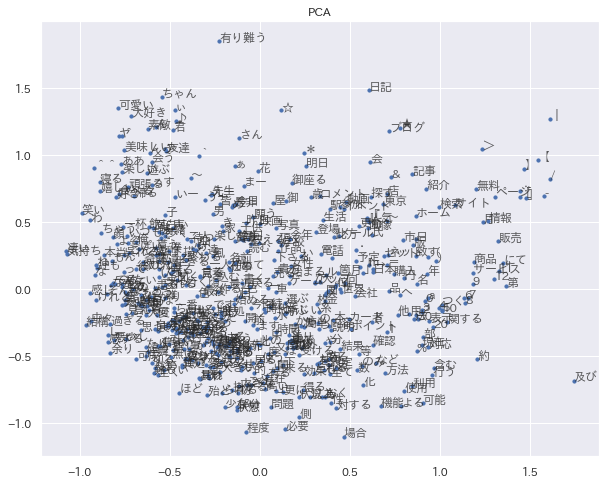

In [ ]:
from sklearn.decomposition import PCA

X_reduced = PCA(n_components=2).fit_transform(vectors_subset)
print(X_reduced.shape)

plt.figure(figsize=FIG_SIZE)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], s=SCATTER_SIZE)
plt.title("PCA")

for label, x, y in zip(
    vectors.index_to_key[:words_n],
    X_reduced[:, 0],
    X_reduced[:, 1]):
    plt.annotate(label, (x,y), fontsize=FONT_SIZE, alpha=ALPHA)

plt.show()

(500, 2)


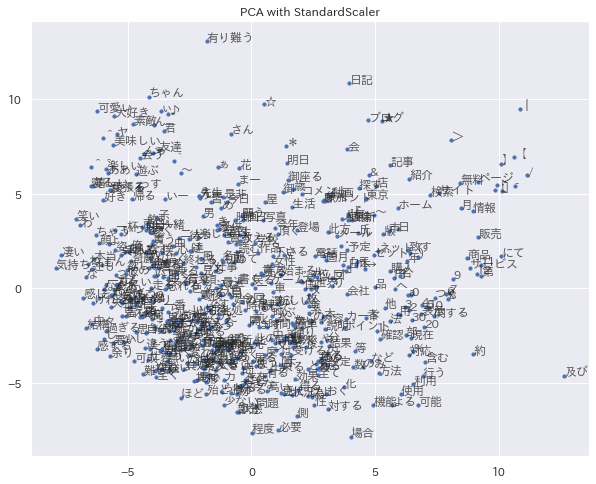

In [ ]:
# PCA with scaling
# Often PCA is sensitive to the scale, so we may get a better result
# if we normalized each feature by StandardScaler. Here it seems to 
# make no difference, though.
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pca = PCA(n_components=2)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
X_reduced = pipe.fit_transform(vectors_subset)
print(X_reduced.shape)

plt.figure(figsize=FIG_SIZE)
plt.scatter(X_reduced[:,0], X_reduced[:,1], s=SCATTER_SIZE)
plt.title("PCA with StandardScaler")

for label, x, y in zip(
    vectors.index_to_key[:words_n],
    X_reduced[:,0],
    X_reduced[:,1]):
    plt.annotate(label, (x,y), fontsize=FONT_SIZE, alpha=ALPHA)

plt.show()

<a name='4.1.3'></a><a id='4.1.3'></a>
## 4.1.3 Training Japanese Word Embeddings with Gensim
<a href="#top">[back to top]</a>

Train Japanese word embeddings from scratch.

Here, we are not using chiVe at all.

In [ ]:
data_wikipedia_path = Path("chp04_shared/wikipedia_data")
print(f"data_wikipedia_path:\t{data_wikipedia_path}")

if not Path(data_wikipedia_path).is_dir():
    data_wikipedia_path.mkdir(parents=True, exist_ok=False)

data_wikipedia_path:	chp04_shared/wikipedia_data


In [ ]:
# Load the Japanese Wikipedia dump
wikipedia_src='wikipedia/20200301.ja'
     
print(f"Use {wikipedia_src}")
HR()
      
ds = tfds.load(
    wikipedia_src, 
    split='train', 
    shuffle_files=True,
    data_dir = data_wikipedia_path
)

assert isinstance(ds, tf.data.Dataset)
print(ds)

Use wikipedia/20200301.ja
--------------------------------------------------


Dl Completed...:   0%|          | 0/66 [00:00<?, ? file/s]

Dataset wikipedia downloaded and prepared to chp04_shared/wikipedia_data/wikipedia/20200301.ja/1.0.0. Subsequent calls will reuse this data.
<PrefetchDataset element_spec={'text': TensorSpec(shape=(), dtype=tf.string, name=None), 'title': TensorSpec(shape=(), dtype=tf.string, name=None)}>


In [ ]:
# Tokenize the text into words (morphemes) with fugashi 
tagger = fugashi.Tagger()

sentences = []
for example in tfds.as_numpy(ds.take(10_000)):
    text = example['text'].decode('utf-8')
    sentence = [w.surface for w in tagger(text)]
    sentences.append(sentence)

In [ ]:
[' '.join(sent[:50]) for sent in sentences[:10]]

['トランス バール また は トランスヴァール Transvaal Vaal River （ バール 川 ） の Trans （ 向こう側 、 北側 ） と いう 意味 に 因む 名前 。 トランスヴァール 共和 国 - 正式 国名 は 南アフリカ 共和 国 （ ） 。 現在 の 南アフリカ 共和 国 （ ） の 北東 部 に',
 'アントニア ・ モーリ （ Antonia Caetana De Paiva Pereira Maury 、 1866 年 3 月 21 日 - 1952 年 1 月 8 日 ） は 、 アメリカ 合衆 国 の 女性 天文 学 者 。 生涯 ニューヨーク 州 の コールド スプリング に 生まれ た 。 祖父 の ジョン ・',
 '牛 銀 本店 （ ぎ ゅうぎんほんてん ） は 、 三重 県 松阪 市 魚町 に ある すき焼き 料理 店 および 同店 を 営む 株式 会社 。 店名 の 牛 銀 は 創業 者 の 小林 銀蔵 の 名 に 由来 し 、 松阪 市 内 に は 和田 金 、',
 '転送 Salsa 20 # ChaCha',
 '転送 海賊 ( ONE PIECE ) # 赤髪 海賊 団',
 'エニ セイ （ ） は 、 ロシア ・ シベリア 鉄道 の モスクワ - クラスノヤルスク 間 を 結ぶ 寝台 急行 列車 。 列車 名 は エニセイ 川 の 河畔 の 大 都市 ・ クラスノヤルスク を 起 終点 と し て いる こと に 因む 。 列車 番号 は No. 55 と',
 '若 浪 順 （ わか なみ じゅん 、 1941 年 3 月 1日 - 2007 年 4 月 16 日 ） は 、 茨城 県 猿島 郡 七 郷村 （ 現 ・ 同県 坂東 市 ） 出身 で 、 立浪 部屋 に 所属 し た 大 相撲 力士 で ある',
 'カンバン 、 かんばん は 、 ジャスト イン タイム 生産 システム で 用い られる 生産 の 指示 票 。 欧 語 で も 日本 語 を 音訳 し て と 呼ば れ て いる 。 中国 語 で は 漢字 で と 表記 する 。 概要 通常 は 、 薄い 鉄板',
 '転送 歓楽 街',
 '転送 社会 哲学 *']

In [ ]:
model_dir = data_dir / "models"
model_path = model_dir / "Doc2Vec_model_4_1_3"
print(f"model_dir:\t{model_dir}")
print(f"model_path:\t{model_path}")

if not Path(model_dir).is_dir():
    model_dir.mkdir(parents=True, exist_ok=False)

model_dir:	chp04_01/models
model_path:	chp04_01/models/Doc2Vec_model_4_1_3


In [ ]:
# Create a Gensim Word2Vec model
# Build the vocabulary set
# Start the training by calling the train() method

if not Path(model_path).is_file():
    print(f"Creating and training model {model_path}")
    
    model = gensim.models.Word2Vec(
        vector_size=100,
        window=5,
        min_count=5
    )
    
    model.build_vocab(sentences)
    
    model.train(
        sentences,
        total_examples=model.corpus_count,
        epochs=10,
        report_delay=1
    )
    
    print("Done training")
    model.save(str(model_path))

else:
    print(f"{model_path} exists")

Creating and training model chp04_01/models/Doc2Vec_model_4_1_3
Done training


We can use KeyedVectors from this model via `model.wv`.

This is the same type as the previously created vector via `gensim.models.KeyedVectors.load_word2vec_format()`

Make sure we can load the saved model and continue.

In [ ]:
# Continue training with the loaded model.
model = gensim.models.Word2Vec.load(str(model_path))

print(type(model))
print(model)
HR()
print(type(model.wv))
print(model.wv)
print(f"{len(model.wv):,}")
HR()
print('ネコ' in model.wv)
print('猫' in model.wv)

<class 'gensim.models.word2vec.Word2Vec'>
Word2Vec<vocab=57515, vector_size=100, alpha=0.025>
--------------------------------------------------
<class 'gensim.models.keyedvectors.KeyedVectors'>
KeyedVectors<vector_size=100, 57515 keys>
57,515
--------------------------------------------------
True
True


In [ ]:
# Find related words to the given query with the trained word embeddings
# Find the most similar words to ネコ neko "cat"?
model.wv.most_similar(positive=["ネコ"])

[('香り', 0.6892638802528381),
 ('昆虫', 0.6636019349098206),
 ('習慣', 0.6401277184486389),
 ('味わい', 0.6360853314399719),
 ('アザラシ', 0.6226228475570679),
 ('焼き', 0.6187594532966614),
 ('果実', 0.6153483390808105),
 ('食害', 0.6132727265357971),
 ('肉', 0.6109013557434082),
 ('感覚', 0.6016896963119507)]

In [ ]:
# Find the most similar words to 猫
model.wv.most_similar(positive=["猫"])

[('魔女', 0.788178563117981),
 ('巫女', 0.7302543520927429),
 ('天使', 0.7298491597175598),
 ('女の子', 0.710567057132721),
 ('男の子', 0.7032473683357239),
 ('帽子', 0.6943685412406921),
 ('小鳥', 0.693886399269104),
 ('メイド', 0.6857389211654663),
 ('相棒', 0.6850834488868713),
 ('誘惑', 0.6848741769790649)]

In [ ]:
# Use conjugated verb forms to retrieve similar words.
# Find the most similar words to 言わ
model.wv.most_similar(positive=["言わ"])

[('いわ', 0.9125999212265015),
 ('評さ', 0.8633514642715454),
 ('思わ', 0.8586500883102417),
 ('称さ', 0.818335235118866),
 ('見なさ', 0.8073378205299377),
 ('みなさ', 0.7815340161323547),
 ('呼ば', 0.7796635031700134),
 ('謳わ', 0.768341064453125),
 ('よば', 0.7571161389350891),
 ('解さ', 0.7554004192352295)]

In [ ]:
model.wv.most_similar(positive=["言っ"])

[('話し', 0.8864073753356934),
 ('思っ', 0.8779544234275818),
 ('言い', 0.8181469440460205),
 ('答え', 0.814296543598175),
 ('語っ', 0.8126689195632935),
 ('評し', 0.782031774520874),
 ('泣い', 0.7724810242652893),
 ('良かっ', 0.767932116985321),
 ('違っ', 0.7632041573524475),
 ('思う', 0.758331835269928)]

In [ ]:
model.wv.most_similar(positive=["言う"])

[('呼ぶ', 0.810407280921936),
 ('いう', 0.7356356978416443),
 ('言える', 0.7328440546989441),
 ('いえる', 0.7094685435295105),
 ('書く', 0.7084574103355408),
 ('考える', 0.7061054110527039),
 ('みなす', 0.7004954218864441),
 ('言い', 0.6938197612762451),
 ('いい', 0.6893551349639893),
 ('呼び', 0.6858577728271484)]

In [ ]:
model.wv.most_similar(positive=["言え"])

[('いえ', 0.8751643896102905),
 ('思え', 0.8589430451393127),
 ('考えれ', 0.7902331948280334),
 ('勝て', 0.7874168157577515),
 ('なれ', 0.7838344573974609),
 ('比べれ', 0.7665421366691589),
 ('なら', 0.7661851644515991),
 ('無けれ', 0.765617311000824),
 ('みれ', 0.7647502422332764),
 ('見れ', 0.7634344100952148)]

---
Previous examples


In [ ]:
model.wv.most_similar(positive=['沖縄', '札幌'], negative=['那覇'])

[('福岡', 0.6091886758804321),
 ('神奈川', 0.5815738439559937),
 ('北海道', 0.5797712802886963),
 ('広島', 0.5759788155555725),
 ('山形', 0.5701645016670227),
 ('関東', 0.5660456418991089),
 ('福島', 0.5581421256065369),
 ('静岡', 0.5575130581855774),
 ('鹿児島', 0.5547534823417664),
 ('千葉', 0.5490267276763916)]

In [ ]:
model.wv.doesnt_match(['新宿', '渋谷', '品川', '池袋', '大手町'])

'大手町'

In [ ]:
model.wv.most_similar(positive=['ドッグ', '猫'], negative=['犬'])

[('トーン', 0.6853063106536865),
 ('レディ', 0.6731308102607727),
 ('スラッシュ', 0.6714087128639221),
 ('ピース', 0.6509339809417725),
 ('プラ', 0.6493442058563232),
 ('イエロー', 0.645709753036499),
 ('ツー', 0.6417790055274963),
 ('リア', 0.6343954205513),
 ('モン', 0.6334937214851379),
 ('グレー', 0.632075309753418)]

In [ ]:
model.wv.doesnt_match(['新宿', '渋谷', '品川', '池袋', '大手町'])

'大手町'

In [ ]:
model.wv.doesnt_match("新宿 渋谷 品川 池袋 大手町".split())

'大手町'

### Visualization

In [ ]:
model.wv.vectors.shape

(57515, 100)

In [ ]:
vectors_subset = model.wv.vectors[:words_n]
vectors_subset.shape

(500, 100)

In [ ]:
# Quick check of the data
import pandas as pd

df = pd.DataFrame(vectors_subset)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.365754,0.450128,-0.030335,-0.736380,-0.173413,0.921855,-0.160828,-0.747488,-0.118966,0.371668,...,-0.075126,-0.152950,0.089374,-0.491587,0.451219,0.143154,-0.843191,-0.001225,0.135058,-0.433653
std,1.778255,2.165058,1.903838,2.014910,1.588403,1.888700,1.939368,1.910070,2.016112,1.752891,...,1.770388,1.716031,1.696569,1.735364,1.741787,1.728054,1.935079,1.861923,1.775029,1.932036
min,-7.354509,-7.356205,-5.237161,-6.465519,-5.732684,-4.669811,-6.587787,-6.755614,-7.134017,-4.580178,...,-5.337174,-6.806190,-6.399196,-5.672789,-5.016518,-4.840813,-6.813704,-5.624319,-7.209422,-6.685842
25%,-0.742470,-0.881053,-1.366641,-1.843027,-1.159306,-0.202557,-1.431979,-1.951709,-1.421642,-0.796545,...,-1.111957,-1.102816,-0.914235,-1.600428,-0.728283,-1.037288,-2.099435,-1.307873,-1.131684,-1.528290
50%,0.445687,0.454336,-0.137328,-0.705814,-0.120405,0.847204,-0.210578,-0.737703,-0.094638,0.327563,...,-0.021558,-0.121502,0.089019,-0.482301,0.512244,0.199966,-0.770635,-0.031009,0.258907,-0.284562
75%,1.504142,1.926789,1.152387,0.487958,0.794403,2.127670,1.200647,0.445139,1.108857,1.399550,...,1.112376,0.931982,1.255563,0.669299,1.661278,1.241757,0.352463,1.308333,1.290224,0.960474
max,5.482250,5.643952,6.820467,5.317184,5.084131,6.292913,7.634797,6.401010,5.670796,5.998808,...,6.202854,4.366300,5.329793,4.424128,5.444728,5.573605,6.441188,5.568597,5.295759,5.049510


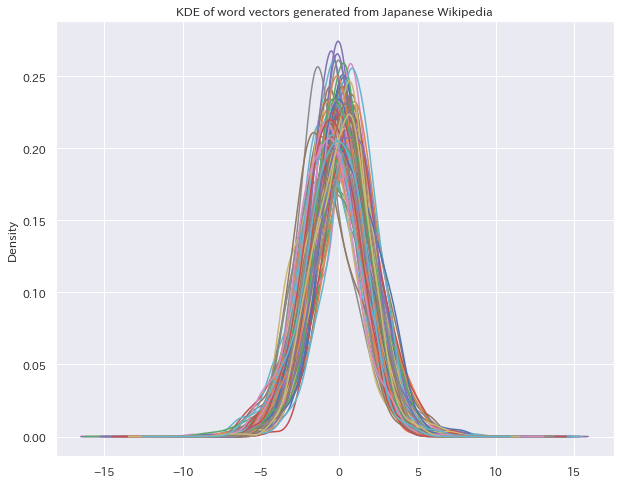

In [ ]:
# The data does not appear to be normalized.
df.plot.kde(legend=False, figsize=FIG_SIZE)
plt.title("KDE of word vectors generated from Japanese Wikipedia")
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 7.045822
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.681549
[t-SNE] KL divergence after 1000 iterations: 1.149491
Done
(500, 2)


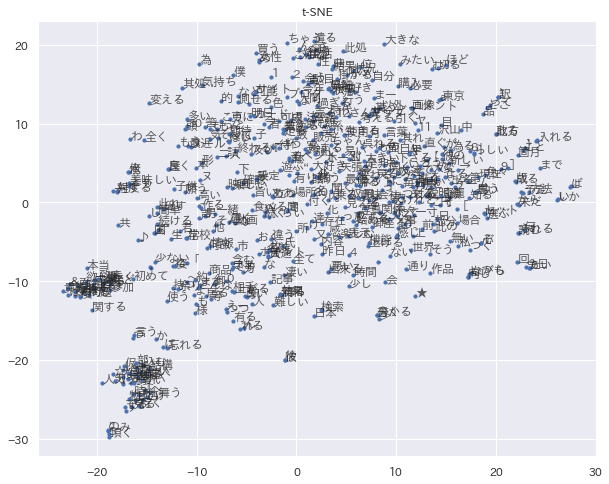

In [ ]:
# Map word embeddings to two-dimensional vectors.
# This is an embedding of the training data in low-dimensional space.

# First, convert affinities of data points to probabilities.
x_embedded_prob = TSNE(
    n_components=2, # Use for a 2D graph
    random_state=42,
    learning_rate=200,
    verbose=1
)

# Return ndarray of shape (n_samples, n_components)
x_embedded = x_embedded_prob.fit_transform(vectors_subset)
print("Done")
print(x_embedded.shape)

plt.figure(figsize=FIG_SIZE)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], s=SCATTER_SIZE)
plt.title("t-SNE")

for label, x, y in zip(
    vectors.index_to_key[:words_n],
    x_embedded[:, 0],
    x_embedded[:, 1]):
    plt.annotate(label, (x,y), fontsize=FONT_SIZE, alpha=ALPHA)

plt.show()

(500, 2)


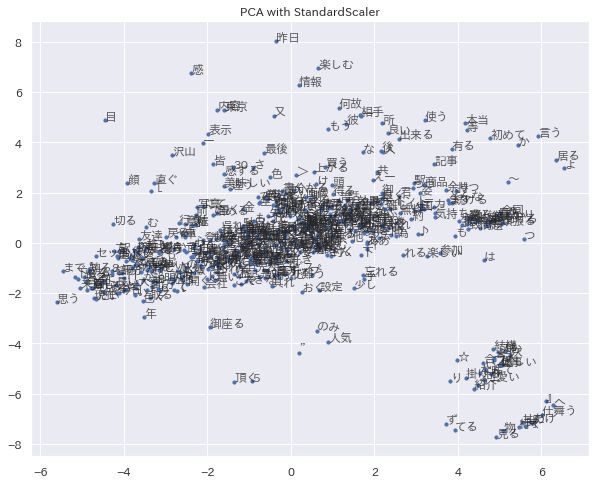

In [ ]:
# PCA with scaling
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pca = PCA(n_components=2)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
X_reduced = pipe.fit_transform(vectors_subset)
print(X_reduced.shape)

plt.figure(figsize=FIG_SIZE)
plt.scatter(X_reduced[:,0], X_reduced[:,1], s=SCATTER_SIZE)
plt.title("PCA with StandardScaler")

for label, x, y in zip(
    vectors.index_to_key[:words_n],
    X_reduced[:,0],
    X_reduced[:,1]):
    plt.annotate(label, (x,y), fontsize=FONT_SIZE, alpha=ALPHA)

plt.show()

In [ ]:
!tree chp04_01 

/bin/bash: tree: command not found


<a name='5.2.2.2'></a><a id='5.2.2.2'></a>
### 5.2.2.2 Saving Model artifacts to Google Drive
<a href="#top">[back to top]</a>

https://drive.google.com/drive/my-drive

In [ ]:
# Set PUSH_TO_GD to True if you want to push chp05_02 to Google Drive 
PUSH_TO_GD = False

if IS_COLAB and PUSH_TO_GD:
    from google.colab import drive

    drive.mount('/content/drive', force_remount=True)
    HR()

    print("Overwriting /content/drive/MyDrive/chp04_01")

    # Have to manually create subdirectories on Google Drive
    !mkdir -p /content/drive/MyDrive/chp04_01/models

    shutil.copytree(
        '/content/chp04_01/models', 
        '/content/drive/MyDrive/chp04_01/models', 
        dirs_exist_ok=True
    )
    HR()

    print("Check contents of chp04_01:")
    !du -ah /content/drive/MyDrive/chp04_01/models --max-depth=2 | sort -h